In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

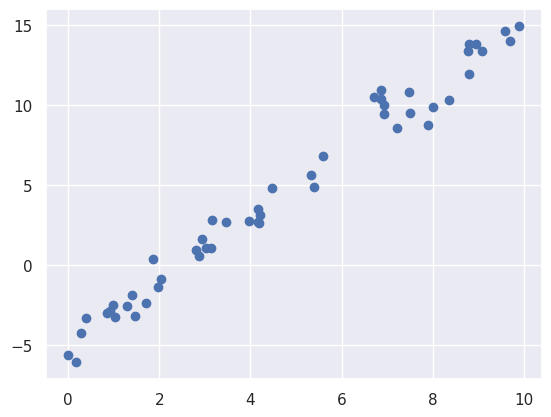

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x -5 + rng.randn(50)
plt.scatter(x, y)

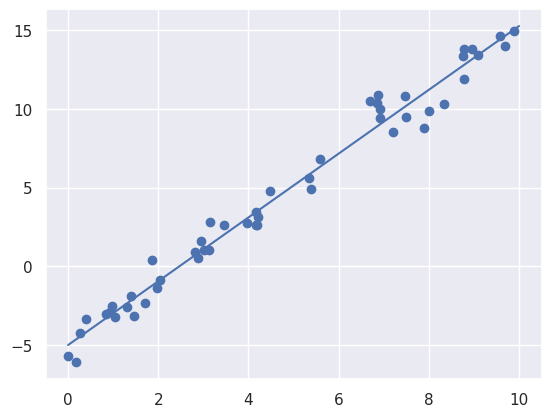

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True) # instercept: 截距

model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

In [4]:
print("Model slope: ", model.coef_[0])
print("Model intercept: ", model.intercept_)

Model slope:  2.0272088103606953
Model intercept:  -4.998577085553204


In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])
model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000033
[ 1.5 -2.   1. ]


### 基函數迴歸(Basis Function Regression)
$$
y = a_{0} + a_{1}x_{1} + a_{2}x_{2}...
$$
從一維輸入$x$建立$x_{1}$、$x_{2}$等，讓$x_{n}=f_{n}(x)$，如果$f_{n}(x)=x^{n}$則模型為多項式迴歸

**NOTE:** 以上仍為**線性模型**，因為係數彼此之間不會有乘或是除的關係

### Polynomial basis functions

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None]) # x[:, None] == x[:, np.newaxis]

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

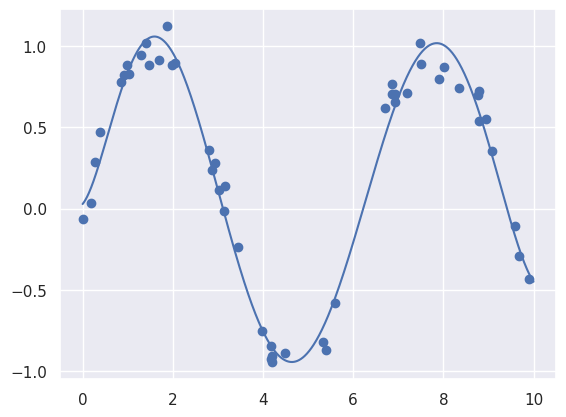

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression()) # 7階多項式 + 線性迴歸

rng = np.random.RandomState(1)
x= 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis]) # xfit is from Linear Regression example

plt.scatter(x, y)
plt.plot(xfit, yfit)

### Gaussian biasis functions

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input."""

    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X , y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

(0.0, 10.0)

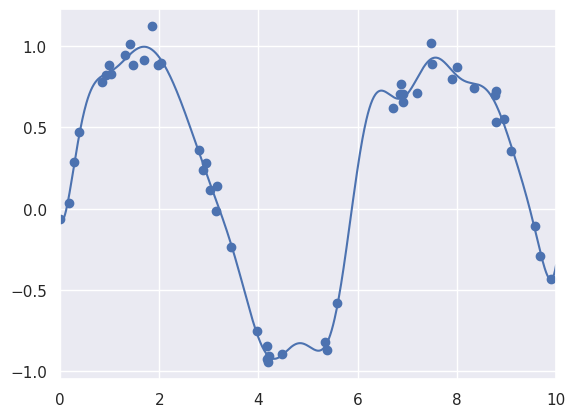

In [9]:
gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10)

(-1.5, 1.5)

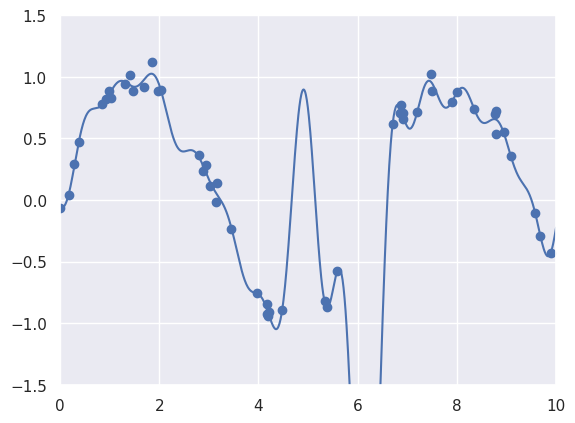

In [10]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)

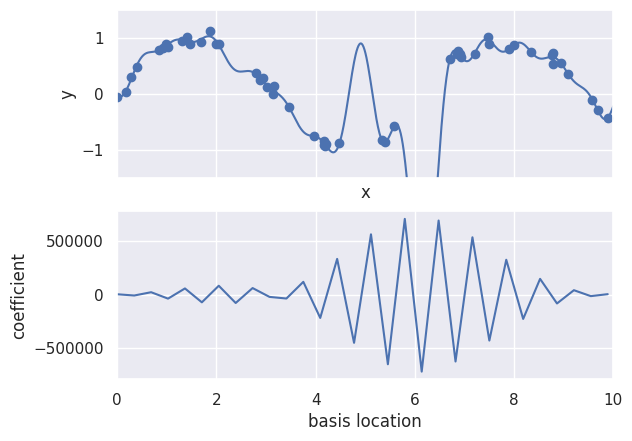

In [11]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel="x", ylabel="y", ylim=(-1.5, 1.5))

    if title:
        ax[0].set_title(title)
    
    ax[1].plot(model.steps[0][1].centers_, model.steps[1][1].coef_)
    ax[1].set(xlabel="basis location", ylabel="coefficient", xlim=(0, 10))

model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

### 正規化
- Ridge regularization($L_{2}$ regularization)
- Lasso reguarization($L_{1}$ regularization)

#### Ridge regularization(Tikhonov 正規化)
- 處罰模型係數的平方和(2-norm)
- penalty: $P = \alpha\sum_{n=1}^{N}\theta_{n}^{2}$

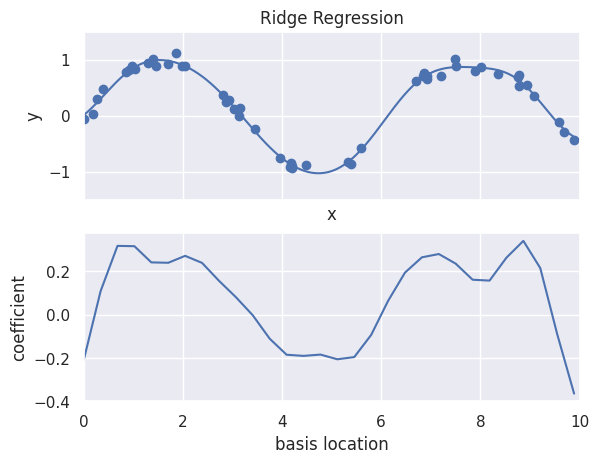

In [12]:
from sklearn.linear_model import Ridge
# alpha -> 0: 接近線性迴歸； alpha -> 無限大: 所有模型的回應都會被抑制(對函數優化不利?!)
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title="Ridge Regression")

#### Lasso regularization
- 以迴歸係數絕對值的和(1-norms)作為處罰
- penalty: $P = \alpha\sum_{n=1}^{N}|\theta_{n}|$
- 傾向利於分散模型，優先把模型係數設定剛好0

/home/lingwenpan/miniconda3/envs/data_science/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-03, tolerance: 2.065e-03
  model = cd_fast.enet_coordinate_descent(


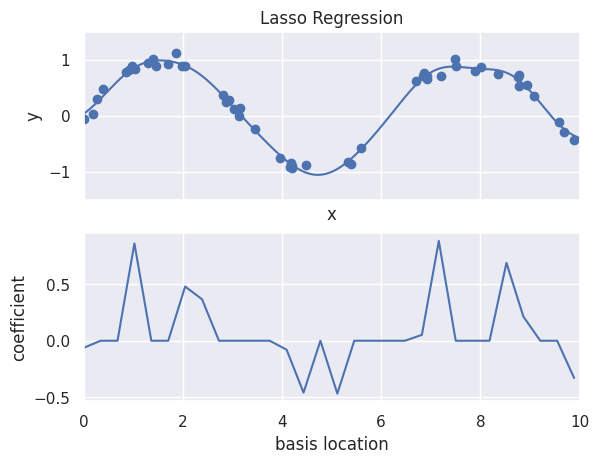

In [13]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title="Lasso Regression")

### 範例: 自行車流量

In [14]:
# data source:
# ch3/data/FremontBridge.csv
# ch5/data/3499062.csv(weather) -> only get data from 2022/08/01 to 2023/02/28

In [39]:
import pandas as pd
counts = pd.read_csv("../ch3/data/FremontBridge.csv", index_col="Date", parse_dates=True)
weather = pd.read_csv("data/3499062.csv", index_col="DATE", parse_dates=True)

/tmp/ipykernel_3028/3328804071.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv("../ch3/data/FremontBridge.csv", index_col="Date", parse_dates=True)


In [40]:
counts.head()

,"Fremont Bridge Sidewalks, south of N 34th St","Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk","Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk"
Date,,,
2022-08-01 00:00:00,23.0,7.0,16.0
2022-08-01 01:00:00,12.0,5.0,7.0
2022-08-01 02:00:00,3.0,0.0,3.0
2022-08-01 03:00:00,5.0,2.0,3.0
2022-08-01 04:00:00,10.0,2.0,8.0


In [41]:
daily = counts.resample("d").sum()
daily["Total"] = daily.sum(axis=1)
daily = daily[["Total"]]

In [42]:
from datetime import datetime
daily.loc[datetime(2012, 10, 3)]

Total    7042.0
Name: 2012-10-03 00:00:00, dtype: float64

In [43]:
# drop data before 2022/08/01
daily = daily.loc[datetime(2022, 8, 1):]

In [44]:
daily.head()

,Total
Date,
2022-08-01,6934.0
2022-08-02,7614.0
2022-08-03,7952.0
2022-08-04,5972.0
2022-08-05,6440.0


In [45]:
daily.tail()

,Total
Date,
2023-02-24,2306.0
2023-02-25,1712.0
2023-02-26,1792.0
2023-02-27,2418.0
2023-02-28,3162.0


In [46]:
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [47]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays("2022", "2023")
daily = daily.join(pd.Series(1, index=holidays, name="holiday"))
daily["holiday"].fillna(0, inplace=True)

In [48]:
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2022-08-01,6934.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-02,7614.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-03,7952.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-08-04,5972.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-08-05,6440.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-02-24,2306.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-02-25,1712.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2023-02-26,1792.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [49]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date."""
    days = (date - datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi /365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m , 0, 2))) / 180.

<Axes: xlabel='Date'>

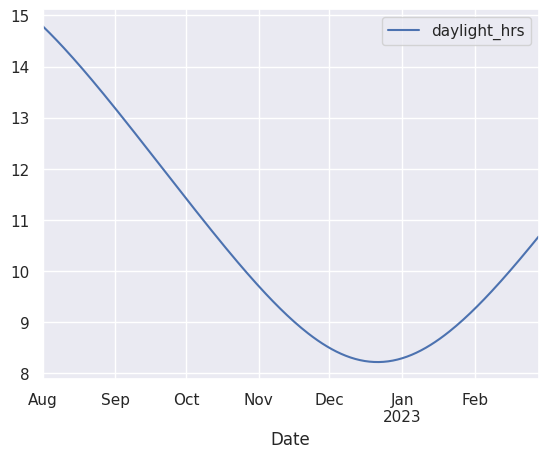

In [50]:
daily["daylight_hrs"] = list(map(hours_of_daylight, daily.index))
daily[["daylight_hrs"]].plot()

In [51]:
# temperatures are in 1/10 deg C; convert to C
weather["TMIN"] /= 10
weather["TMAX"] /= 10
weather["Temp(C)"] = 0.5 * (weather["TMIN"] + weather["TMAX"])

# percip is in 1/10 mm; convert to inches
weather["PRCP"] /= 254
weather["dry day"] = (weather["PRCP"] == 0).astype(int)

daily = daily.join(weather[["PRCP", "Temp(C)", "dry day"]])

In [52]:
daily["annual"] = (daily.index - daily.index[0]).days / 365.

In [53]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp(C),dry day,annual
Date,,,,,,,,,,,,,,
2022-08-01,6934.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.793135,0.0,7.10,1,0.000000
2022-08-02,7614.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14.748356,0.0,6.75,1,0.002740
2022-08-03,7952.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.702903,0.0,6.35,1,0.005479
2022-08-04,5972.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.656796,0.0,6.40,1,0.008219
2022-08-05,6440.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14.610058,0.0,6.55,1,0.010959


In [54]:
col_names = [
    "Mon",
    "Tue",
    "Wed",
    "Thu",
    "Fri",
    "Sat",
    "Sun",
    "holiday",
    "daylight_hrs",
    "PRCP",
    "dry day",
    "Temp(C)",
    "annual"
]
X = daily[col_names]
y = daily["Total"]

In [55]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily["predicted"] = model.predict(X)

<Axes: xlabel='Date'>

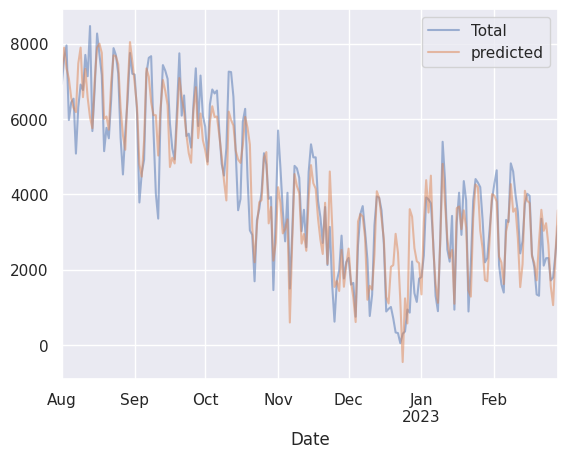

In [56]:
daily[["Total", "predicted"]].plot(alpha=0.5)

In [57]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              -1188.868613
Tue               -294.361407
Wed               -566.285757
Thu               -862.880961
Fri              -1453.653132
Sat              -1996.657126
Sun              -2462.304785
holiday           -908.047085
daylight_hrs       208.915669
PRCP           -427032.492704
dry day            685.820814
Temp(C)            655.145661
annual           -1348.022070
dtype: float64

In [58]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

In [60]:
pd.DataFrame(
    {
        "effect": params.round(0),
        "error": err.round(0),
    }
)
# Mon~Sun: covid?

,effect,error
Mon,-1189.0,661.0
Tue,-294.0,690.0
Wed,-566.0,699.0
Thu,-863.0,684.0
Fri,-1454.0,668.0
Sat,-1997.0,652.0
Sun,-2462.0,655.0
holiday,-908.0,547.0
daylight_hrs,209.0,59.0
PRCP,-427032.0,80689.0
